In [1]:
import time
import datetime

import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.decomposition import PCA

import annoy
from annoy import AnnoyIndex
import random

import antares_client

import warnings
warnings.filterwarnings("ignore")

In [2]:
import requests
from requests.auth import HTTPBasicAuth
import astropy.table as at
import matplotlib
from matplotlib.transforms import Bbox
from matplotlib.backends.backend_pdf import PdfPages
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
import astropy.units as u
from astropy.visualization import PercentileInterval, AsinhStretch
from astroquery.mast import Catalogs
from astroquery.sdss import SDSS
from astroquery.simbad import Simbad

import light_curve as lc
from itertools import chain
import light_curve as lc
from astropy.table import MaskedColumn

from PIL import Image
import os
import sys
import shutil
import glob
import json

import math

import warnings
warnings.filterwarnings("ignore")

import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import os
import sys
import annoy
from annoy import AnnoyIndex
import random



from IPython.display import display_markdown

from collections import Counter

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA

from alerce.core import Alerce
alerce = Alerce()

import antares_client



import astro_ghost
# from astro_ghost.PS1QueryFunctions import getAllPostageStamps
# from astro_ghost.TNSQueryFunctions import getTNSSpectra
# from astro_ghost.NEDQueryFunctions import getNEDSpectra
from astro_ghost.ghostHelperFunctions import getTransientHosts, getGHOST
from astropy.coordinates import SkyCoord
from astropy import units as u
from datetime import datetime
import tempfile

# Throw RA/DEC into ghost with just DLR method, gentle starcut
# Sets environ var to find ghost.csv
os.environ['GHOST_PATH'] = './host_info'
# Then don't use getGHOST(real=True, verbose=verbose)
getGHOST(real=True,verbose=False)

from timeout_decorator import timeout, TimeoutError
@timeout(120)  # Set a timeout of 60 seconds to query GHOST throughput APIs for host galaxy data
def getTransientHosts_with_timeout(**args):
    #time.sleep(6) #- to test
    return astro_ghost.ghostHelperFunctions.getTransientHosts(**args)


def replace_magn_with_flux(s):
    if 'magnitude' in s:
        return s.replace('magnitudes', 'fluxes').replace('magnitude', 'flux')
    return f'{s} for flux light curve'

def create_base_features_class(
        magn_extractor,
        flux_extractor,
        bands=('R', 'g',),
    ):
    feature_names = ([f'{name}_magn' for name in magn_extractor.names]
                     + [f'{name}_flux' for name in flux_extractor.names])
    
    property_names = {band: [f'feature_{name}_{band}'.lower()
                             for name in feature_names]
                      for band in bands}
    
    features_count = len(feature_names)
    
    return feature_names, property_names, features_count


MAGN_EXTRACTOR = lc.Extractor(
    lc.Amplitude(),
    lc.AndersonDarlingNormal(),
    lc.BeyondNStd(1.0),
    lc.BeyondNStd(2.0),
    lc.Cusum(),
    lc.EtaE(),
    lc.InterPercentileRange(0.02),
    lc.InterPercentileRange(0.1),
    lc.InterPercentileRange(0.25),
    lc.Kurtosis(),
    lc.LinearFit(),
    lc.LinearTrend(),
    lc.MagnitudePercentageRatio(0.4, 0.05),
    lc.MagnitudePercentageRatio(0.2, 0.05),
    lc.MaximumSlope(),
    lc.Mean(),
    lc.MedianAbsoluteDeviation(),
    lc.PercentAmplitude(),
    lc.PercentDifferenceMagnitudePercentile(0.05),
    lc.PercentDifferenceMagnitudePercentile(0.1),
    lc.MedianBufferRangePercentage(0.1),
    lc.MedianBufferRangePercentage(0.2),
    lc.Periodogram(
        peaks=5,
        resolution=10.0,
        max_freq_factor=2.0,
        nyquist='average',
        fast=True,
        features=(
            lc.Amplitude(),
            lc.BeyondNStd(2.0),
            lc.BeyondNStd(3.0),
            lc.StandardDeviation(),
        ),
    ),
    lc.ReducedChi2(),
    lc.Skew(),
    lc.StandardDeviation(),
    lc.StetsonK(),
    lc.WeightedMean(),
)

FLUX_EXTRACTOR = lc.Extractor(
    lc.AndersonDarlingNormal(),
    lc.Cusum(),
    lc.EtaE(),
    lc.ExcessVariance(),
    lc.Kurtosis(),
    lc.MeanVariance(),
    lc.ReducedChi2(),
    lc.Skew(),
    lc.StetsonK(),
)

def remove_simultaneous_alerts(table):
    """Remove alert duplicates"""
    dt = np.diff(table['ant_mjd'], append=np.inf)
    return table[dt != 0]
    
def get_detections(photometry, band):
    """Extract clean light curve in given band from locus photometry"""
    band_lc = photometry[(photometry['ant_passband'] == band) & (~photometry['ant_mag'].isna())]
    idx = ~MaskedColumn(band_lc['ant_mag']).mask
    detections = remove_simultaneous_alerts(band_lc[idx])
    return detections

GHOST database already exists in the install path!


In [3]:
# From 106 available features from Kostya's lc_feature_extractor, use the 82 from SNAD Miner paper 
# R and g bands
feature_names_r_g = ['feature_amplitude_magn_r', 
                 'feature_anderson_darling_normal_magn_r',
                 'feature_beyond_1_std_magn_r', 
                 'feature_beyond_2_std_magn_r',
                 'feature_cusum_magn_r', 
                 #'feature_eta_e_magn_r',
                 'feature_inter_percentile_range_2_magn_r',
                 'feature_inter_percentile_range_10_magn_r',
                 'feature_inter_percentile_range_25_magn_r', 
                 'feature_kurtosis_magn_r',
                 'feature_linear_fit_slope_magn_r',
                 'feature_linear_fit_slope_sigma_magn_r',
                 #'feature_linear_fit_reduced_chi2_magn_r', 
                 #'feature_linear_trend_magn_r', # cadence removal
                 #'feature_linear_trend_sigma_magn_r',  # cadence removal
                 'feature_magnitude_percentage_ratio_40_5_magn_r',
                 'feature_magnitude_percentage_ratio_20_5_magn_r',
                 #'feature_maximum_slope_magn_r',
                 'feature_mean_magn_r',
                 'feature_median_absolute_deviation_magn_r',
                 'feature_percent_amplitude_magn_r',
                 'feature_median_buffer_range_percentage_10_magn_r',
                 'feature_median_buffer_range_percentage_20_magn_r',
                 'feature_percent_difference_magnitude_percentile_5_magn_r',
                 'feature_percent_difference_magnitude_percentile_10_magn_r',
                 #'feature_period_0_magn_r',  # should be negated
                 #'feature_period_s_to_n_0_magn_r', # cadence removal
                 #'feature_period_1_magn_r', 
                 #'feature_period_s_to_n_1_magn_r', # cadence removal
                 #'feature_period_2_magn_r', 
                 #'feature_period_s_to_n_2_magn_r', # cadence removal
                 #'feature_period_3_magn_r', 
                 #'feature_period_s_to_n_3_magn_r', # cadence removal
                 #'feature_period_4_magn_r', 
                 #'feature_period_s_to_n_4_magn_r', # cadence removal
                 #'feature_periodogram_amplitude_magn_r',
                 #'feature_periodogram_beyond_2_std_magn_r',  # cadence removal
                 #'feature_periodogram_beyond_3_std_magn_r',  # cadence removal
                 #'feature_periodogram_standard_deviation_magn_r',   # cadence removal
                 #'feature_chi2_magn_r',
                 'feature_skew_magn_r', 
                 'feature_standard_deviation_magn_r',
                 'feature_stetson_k_magn_r',
                 'feature_weighted_mean_magn_r',
                 'feature_anderson_darling_normal_flux_r', 
                 'feature_cusum_flux_r',
                 #'feature_eta_e_flux_r', 
                 'feature_excess_variance_flux_r',
                 'feature_kurtosis_flux_r', 
                 'feature_mean_variance_flux_r',
                 #'feature_chi2_flux_r', 
                 'feature_skew_flux_r',
                 'feature_stetson_k_flux_r',

                 'feature_amplitude_magn_g', 
                 'feature_anderson_darling_normal_magn_g',
                 'feature_beyond_1_std_magn_g', 
                 'feature_beyond_2_std_magn_g',
                 'feature_cusum_magn_g', 
                 #'feature_eta_e_magn_g',
                 'feature_inter_percentile_range_2_magn_g',
                 'feature_inter_percentile_range_10_magn_g',
                 'feature_inter_percentile_range_25_magn_g', 
                 'feature_kurtosis_magn_g',
                 'feature_linear_fit_slope_magn_g',
                 'feature_linear_fit_slope_sigma_magn_g',
                 #'feature_linear_fit_reduced_chi2_magn_g', 
                 #'feature_linear_trend_magn_g', # cadence removal
                 #'feature_linear_trend_sigma_magn_g',  # cadence removal
                 'feature_magnitude_percentage_ratio_40_5_magn_g',
                 'feature_magnitude_percentage_ratio_20_5_magn_g',
                 #'feature_maximum_slope_magn_g', 
                 'feature_mean_magn_g',
                 'feature_median_absolute_deviation_magn_g',
                 'feature_median_buffer_range_percentage_10_magn_g',
                 'feature_median_buffer_range_percentage_20_magn_g',
                 'feature_percent_amplitude_magn_g',
                 'feature_percent_difference_magnitude_percentile_5_magn_g',
                 'feature_percent_difference_magnitude_percentile_10_magn_g',
                 #'feature_period_0_magn_g',  # should be negated
                 #'feature_period_s_to_n_0_magn_g', # cadence removal
                 #'feature_period_1_magn_g', 
                 #'feature_period_s_to_n_1_magn_g', # cadence removal
                 #'feature_period_2_magn_g', 
                 #'feature_period_s_to_n_2_magn_g', # cadence removal
                 #'feature_period_3_magn_g', 
                 #'feature_period_s_to_n_3_magn_g', # cadence removal
                 #'feature_period_4_magn_g', 
                 #'feature_period_s_to_n_4_magn_g', # cadence removal
                 #'feature_periodogram_amplitude_magn_g',
                 #'feature_periodogram_beyond_2_std_magn_g',  # cadence removal
                 #'feature_periodogram_beyond_3_std_magn_g', # cadence removal
                 #'feature_periodogram_standard_deviation_magn_g',  # cadence removal
                 #'feature_chi2_magn_g',
                 'feature_skew_magn_g', 
                 'feature_standard_deviation_magn_g',
                 'feature_stetson_k_magn_g', 
                 'feature_weighted_mean_magn_g',
                 'feature_anderson_darling_normal_flux_g', 
                 'feature_cusum_flux_g',
                 #'feature_eta_e_flux_g', 
                 'feature_excess_variance_flux_g',
                 'feature_kurtosis_flux_g', 
                 'feature_mean_variance_flux_g',
                 #'feature_chi2_flux_g', 
                 'feature_skew_flux_g',
                 'feature_stetson_k_flux_g']   

feature_names_hostgal = [
    #  'Unnamed: 0',
    #  'level_0',
    #  'index',
    #  'objName',
    #  'objAltName1',
    #  'objAltName2',
    #  'objAltName3',
    #  'objID',
    #  'uniquePspsOBid',
    #  'ippObjID',
    #  'surveyID',
    #  'htmID',
    #  'zoneID',
    #  'tessID',
    #  'projectionID',
    #  'skyCellID',
    #  'randomID',
    #  'batchID',
    #  'dvoRegionID',
    #  'processingVersion',
    #  'objInfoFlag',
    #  'qualityFlag',
    #  'raStack',
    #  'decStack',
    #  'raStackErr',
    #  'decStackErr',
    #  'raMean',
    #  'decMean',
    #  'raMeanErr',
    #  'decMeanErr',
    #  'epochMean',
    #  'posMeanChisq',
    #  'cx',
    #  'cy',
    #  'cz',
    #  'lambda',
    #  'beta',
    #  'l',
    #  'b',
    #  'nStackObjectRows',
    #  'nStackDetections',
    #  'nDetections',
    #  'ng',
    #  'nr',
    #  'ni',
    #  'nz',
    #  'ny',
    #  'uniquePspsSTid',
    #  'primaryDetection',
    #  'bestDetection',
    #  'gippDetectID',
    #  'gstackDetectID',
    #  'gstackImageID',
    #  'gra',
    #  'gdec',
    #  'graErr',
    #  'gdecErr',
    #  'gEpoch',
    #  'gPSFMag',
    #  'gPSFMagErr',
    #  'gApMag',
    #  'gApMagErr',
    #  'gKronMag',
    #  'gKronMagErr',
    #  'ginfoFlag',
    #  'ginfoFlag2',
    #  'ginfoFlag3',
    #  'gnFrames',
    #  'gxPos',
    #  'gyPos',
    #  'gxPosErr',
    #  'gyPosErr',
    #  'gpsfMajorFWHM',
    #  'gpsfMinorFWHM',
    #  'gpsfTheta',
    #  'gpsfCore',
    #  'gpsfLikelihood',
    #  'gpsfQf',
    #  'gpsfQfPerfect',
    #  'gpsfChiSq',
     'gmomentXX',
     'gmomentXY',
     'gmomentYY',
     'gmomentR1',
     'gmomentRH',
     'gPSFFlux',
    #  'gPSFFluxErr',
     'gApFlux',
    #  'gApFluxErr',
    #  'gApFillFac',
    #  'gApRadius',
     'gKronFlux',
    #  'gKronFluxErr',
     'gKronRad',
    #  'gexpTime',
     'gExtNSigma',
    #  'gsky',
    #  'gskyErr',
    #  'gzp',
    #  'gPlateScale',
    #  'rippDetectID',
    #  'rstackDetectID',
    #  'rstackImageID',
    #  'rra',
    #  'rdec',
    #  'rraErr',
    #  'rdecErr',
    #  'rEpoch',
    # 'rPSFMag',
    #  'rPSFMagErr',
    # 'rApMag',
    #  'rApMagErr',
    # 'rKronMag',
    #  'rKronMagErr',
    #  'rinfoFlag',
    #  'rinfoFlag2',
    #  'rinfoFlag3',
    #  'rnFrames',
    #  'rxPos',
    #  'ryPos',
    #  'rxPosErr',
    #  'ryPosErr',
    #  'rpsfMajorFWHM',
    #  'rpsfMinorFWHM',
    #  'rpsfTheta',
    #  'rpsfCore',
    #  'rpsfLikelihood',
    #  'rpsfQf',
    #  'rpsfQfPerfect',
    #  'rpsfChiSq',
     'rmomentXX',
     'rmomentXY',
     'rmomentYY',
     'rmomentR1',
     'rmomentRH',
    'rPSFFlux',
    #  'rPSFFluxErr',
    'rApFlux',
    #  'rApFluxErr',
    #  'rApFillFac',
    # 'rApRadius',
    'rKronFlux',
    #  'rKronFluxErr',
    'rKronRad',
    #  'rexpTime',
     'rExtNSigma',
    #  'rsky',
    #  'rskyErr',
    #  'rzp',
    #  'rPlateScale',
    #  'iippDetectID',
    #  'istackDetectID',
    #  'istackImageID',
    #  'ira',
    #  'idec',
    #  'iraErr',
    #  'idecErr',
    #  'iEpoch',
    #  'iPSFMag',
    #  'iPSFMagErr',
    #  'iApMag',
    #  'iApMagErr',
    #  'iKronMag',
    #  'iKronMagErr',
    #  'iinfoFlag',
    #  'iinfoFlag2',
    #  'iinfoFlag3',
    #  'inFrames',
    #  'ixPos',
    #  'iyPos',
    #  'ixPosErr',
    #  'iyPosErr',
    #  'ipsfMajorFWHM',
    #  'ipsfMinorFWHM',
    #  'ipsfTheta',
    #  'ipsfCore',
    #  'ipsfLikelihood',
    #  'ipsfQf',
    #  'ipsfQfPerfect',
    #  'ipsfChiSq',
      'imomentXX',
     'imomentXY',
     'imomentYY',
     'imomentR1',
     'imomentRH',
     'iPSFFlux',
    #  'iPSFFluxErr',
     'iApFlux',
    #  'iApFluxErr',
    #  'iApFillFac',
    #  'iApRadius',
     'iKronFlux',
    #  'iKronFluxErr',
     'iKronRad',
    #  'iexpTime',
      'iExtNSigma',
    #  'isky',
    #  'iskyErr',
    #  'izp',
    #  'iPlateScale',
    #  'zippDetectID',
    #  'zstackDetectID',
    #  'zstackImageID',
    #  'zra',
    #  'zdec',
    #  'zraErr',
    #  'zdecErr',
    #  'zEpoch',
    #  'zPSFMag',
    #  'zPSFMagErr',
    #  'zApMag',
    #  'zApMagErr',
    #  'zKronMag',
    #  'zKronMagErr',
    #  'zinfoFlag',
    #  'zinfoFlag2',
    #  'zinfoFlag3',
    #  'znFrames',
    #  'zxPos',
    #  'zyPos',
    #  'zxPosErr',
    #  'zyPosErr',
    #  'zpsfMajorFWHM',
    #  'zpsfMinorFWHM',
    #  'zpsfTheta',
    #  'zpsfCore',
    #  'zpsfLikelihood',
    #  'zpsfQf',
    #  'zpsfQfPerfect',
    #  'zpsfChiSq',
      'zmomentXX',
     'zmomentXY',
     'zmomentYY',
     'zmomentR1',
     'zmomentRH',
     'zPSFFlux',
    # #  'zPSFFluxErr',
     'zApFlux',
    # #  'zApFluxErr',
    # #  'zApFillFac',
    # #  'zApRadius',
     'zKronFlux',
    # #  'zKronFluxErr',
     'zKronRad',
    # #  'zexpTime',
      'zExtNSigma',
    #  'zsky',
    #  'zskyErr',
    #  'zzp',
    #  'zPlateScale',
    #  'yippDetectID',
    #  'ystackDetectID',
    #  'ystackImageID',
    #  'yra',
    #  'ydec',
    #  'yraErr',
    #  'ydecErr',
    #  'yEpoch',
    #  'yPSFMag',
    #  'yPSFMagErr',
    #  'yApMag',
    #  'yApMagErr',
    #  'yKronMag',
    #  'yKronMagErr',
    #  'yinfoFlag',
    #  'yinfoFlag2',
    #  'yinfoFlag3',
    #  'ynFrames',
    #  'yxPos',
    #  'yyPos',
    #  'yxPosErr',
    #  'yyPosErr',
    #  'ypsfMajorFWHM',
    #  'ypsfMinorFWHM',
    #  'ypsfTheta',
    #  'ypsfCore',
    #  'ypsfLikelihood',
    #  'ypsfQf',
    #  'ypsfQfPerfect',
    #  'ypsfChiSq',
      'ymomentXX',
      'ymomentXY',
      'ymomentYY',
      'ymomentR1',
      'ymomentRH',
      'yPSFFlux',
    # #   'yPSFFluxErr',
      'yApFlux',
    # #   'yApFluxErr',
    # #   'yApFillFac',
    # #  'yApRadius',
     'yKronFlux',
    # #  'yKronFluxErr',
     'yKronRad',
    # #  'yexpTime',
      'yExtNSigma',
    #  'ysky',
    #  'yskyErr',
    #  'yzp',
    #  'yPlateScale',
    #  'distance',
    #  'SkyMapper_StarClass',
    #  'gelong',
    #  'g_a',
    #  'g_b',
    #  'g_pa',
    #  'relong',
    #  'r_a',
    #  'r_b',
    #  'r_pa',
    #  'ielong',
    #  'i_a',
    #  'i_b',
    #  'i_pa',
    #  'zelong',
    #  'z_a',
    #  'z_b',
    #  'z_pa',
       'i-z', # try throwing in
    #    'g-r',
    #    'r-i',
    #    'g-i',
    #    'z-y',
    #   'g-rErr',
    #   'r-iErr',
    #   'i-zErr',
    #   'z-yErr',
     'gApMag_gKronMag',
     'rApMag_rKronMag',
     'iApMag_iKronMag',
     'zApMag_zKronMag',
     'yApMag_yKronMag',
     '7DCD', 
    #  'NED_name',
    #  'NED_type',
    #  'NED_vel',
    #  'NED_redshift',
    #  'NED_mag',
    #  'class',
       'dist/DLR',
    #   'dist',
    #  'TransientClass',
    #  'TransientRA',
    #  'TransientDEC'
       ]


lc_and_host_features = feature_names_r_g + feature_names_hostgal

In [61]:
n_estimators=100 #3500
max_depth=35 #35
random_state=11
max_features=35 # {“sqrt”, “log2”, None}, int or float, default=”sqrt” - sqrt(120) ~ 10
#class_weight={"None": 1, "SLSN-II": 1, "SN II": 1, 'SN IIP': 1, 'SN IIb': 1, 'SN IIn': 1, 'SN Ia': 1,
#       'SN Ia-91T-like': 1, 'SN Ib': 1, 'SN Ic': 1, 'SN Ic-BL': 1, 'TDE': 1} #"balanced"
class_weight={"Normal": 1, "Other": 1} #"balanced"

figure_path = f"/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/RFC/SMOTE_train_test_70-30_min14_kneighbors8/cls=binary_n_estimators={n_estimators}_max_depth={max_depth}_rs={random_state}_max_feats={max_features}_cw=balanced/figures"
model_path = f"/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/RFC/SMOTE_train_test_70-30_min14_kneighbors8/cls=binary_n_estimators={n_estimators}_max_depth={max_depth}_rs={random_state}_max_feats={max_features}_cw=balanced/model"
if not os.path.exists(figure_path):
    os.makedirs(figure_path)
    
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(f'{model_path}/cls=binary_n_estimators={n_estimators}_max_depth={max_depth}_rs={random_state}_max_feats={max_features}_cw=balanced.pkl', 'rb') as f:
    clf = pickle.load(f)


def plot_RFC_prob_vs_lc_ztfid(clf, anom_ztfid, anom_thresh, lc_and_hosts_df, lc_and_hosts_df_120d, ref_info):
    anom_thresh = anom_thresh
    anom_obj_df = lc_and_hosts_df_120d

    try:
        pred_prob_anom = 100 * clf.predict_proba(anom_obj_df)
        pred_prob_anom[:, 0] = [round(a, 1) for a in pred_prob_anom[:, 0]]
        pred_prob_anom[:, 1] = [round(b, 1) for b in pred_prob_anom[:, 1]]
        num_anom_epochs = len(np.where(pred_prob_anom[:, 1]>=anom_thresh)[0])
    except:
        print(f"{anom_ztfid} has some NaN host galaxy values from PS1 catalog. Skip!")
        return

    try: 
        anom_idx = lc_and_hosts_df.iloc[np.where(pred_prob_anom[:, 1]>=anom_thresh)[0][0]].obs_num
        anom_idx_is = True
        print("Anomalous during timeseries!")

    except: 
        print(f"Prediction doesn't exceed anom_threshold of {anom_thresh}% for {anom_ztfid}.")
        anom_idx_is = False

    max_anom_score = max(pred_prob_anom[:, 1])
    print("max_anom_score", round(max_anom_score, 1))
    print("num_anom_epochs", num_anom_epochs)
    
    ztf_id_ref = anom_ztfid 

    ref_info = ref_info

    df_ref = ref_info.timeseries.to_pandas()

    df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
    df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

    mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
    mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(7,10))
    ax1.invert_yaxis()
    ax1.errorbar(x=df_ref_r.ant_mjd, y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
                label=f'REF: {ztf_id_ref}')
    ax1.errorbar(x=df_ref_g.ant_mjd, y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
    if anom_idx_is == True:
        ax1.axvline(x=lc_and_hosts_df[lc_and_hosts_df.obs_num == anom_idx].mjd_cutoff.values[0])
        print("MJD crossed thresh:", lc_and_hosts_df[lc_and_hosts_df.obs_num == anom_idx].mjd_cutoff.values[0])
    
    print(f'https://alerce.online/object/{anom_ztfid}')
    ax2.plot(lc_and_hosts_df.mjd_cutoff, pred_prob_anom[:, 0], label='p(Normal)')
    ax2.plot(lc_and_hosts_df.mjd_cutoff, pred_prob_anom[:, 1], label='p(Other)')

    ax1.set_title(anom_ztfid)
    plt.xlabel('MJD')
    ax1.set_ylabel('Magnitude')
    ax2.set_ylabel('Probability (%)')
    plt.legend()
    plt.show()

In [62]:
import datetime
def calculate_mjd(year, month, day):
    # Calculate Julian Date
    a = (14 - month) // 12
    y = year + 4800 - a
    m = month + 12 * a - 3
    julian_date = day + (153 * m + 2) // 5 + 365 * y + y // 4 - y // 100 + y // 400 - 32045
    
    # Calculate Modified Julian Date
    modified_jd = julian_date - 2400000.5
    return modified_jd

# Get current date
current_date = datetime.datetime.now()
year = current_date.year
month = current_date.month
day = current_date.day

# Calculate today's MJD
today_mjd = calculate_mjd(year, month, day)
print("Today's Modified Julian Date:", today_mjd)

Today's Modified Julian Date: 60216.5


In [63]:
%%time

LAISS_RFC_AD_loci = antares_client.search.search(
    {
  "query": {
    "bool": {
      "filter": [
        {
          "terms": {
            "tags": [
              "LAISS_RFC_AD_filter" #"extragalactic" #"desoto_classified" #"extragalactic" #"lc_feature_extractor"
            ]
          }
        }
      ],
        "must": {
        "range": {
          "properties.newest_alert_observation_time" : {
            "gte": today_mjd - 1
          }
        }
       }
      }
    }
  }
)
LAISS_RFC_AD_locus_ids = [l.locus_id for l in LAISS_RFC_AD_loci]

CPU times: user 485 ms, sys: 73 ms, total: 558 ms
Wall time: 6.16 s


## TODO: Make massive dataset bank to compare to - all spec/phot ZTF TNS? For now, just use original dataset bank

In [64]:
# dataset_bank = pd.read_csv('../loci_dbs/alerce_cut/dataset_bank.csv.gz', compression='gzip', index_col=0)

# # from ps1_psc.ipynb
# # used mask (keep_df.pgal_host < 0.5) & (keep_df.pgal_transient < 0.5) 
# keep_df = pd.read_csv(f'../loci_dbs/alerce_cut/keep_df.csv.gz', compression='gzip')
# keep_df = keep_df.drop_duplicates(subset='ztf_object_id', keep='first') # keep first occurance of ztfid
# keep_df = keep_df.set_index('ztf_object_id')

# # merge df1 with df2 on the index and add the 'stamp_cls' column
# keep_df = keep_df.merge(dataset_bank[['stamp_cls']], left_index=True, right_index=True, suffixes=('', '_cls'))

# dataset_bank_orig = dataset_bank[dataset_bank.index.isin(keep_df.index)]
# dataset_bank_orig = dataset_bank_orig[lc_and_host_features]

# dataset_label_orig = list(dataset_bank_orig.index)
dataset_bank_orig = pd.read_csv('../loci_dbs/alerce_cut/dataset_bank_orig_5472objs.csv.gz', compression='gzip', index_col=0)
dataset_bank_orig

,feature_amplitude_magn_r,feature_anderson_darling_normal_magn_r,feature_beyond_1_std_magn_r,feature_beyond_2_std_magn_r,feature_cusum_magn_r,feature_inter_percentile_range_2_magn_r,feature_inter_percentile_range_10_magn_r,feature_inter_percentile_range_25_magn_r,feature_kurtosis_magn_r,feature_linear_fit_slope_magn_r,...,yKronRad,yExtNSigma,i-z,gApMag_gKronMag,rApMag_rKronMag,iApMag_iKronMag,zApMag_zKronMag,yApMag_yKronMag,7DCD,dist/DLR
ztf_object_id,,,,,,,,,,,,,,,,,,,,,
ZTF17aaahrni,1.501946,0.581482,0.333333,0.000000,0.300476,3.003893,2.881442,1.473296,-0.323815,0.000616,...,2.435050,6.442500,0.096600,0.164299,-0.071001,0.051300,-0.024000,-0.145601,22.882911,2.639232
ZTF17aadqidc,0.118791,0.276625,0.428571,0.000000,0.385504,0.237581,0.223594,0.138365,-0.817505,0.013288,...,4.506650,12.795700,0.057600,0.102600,0.163198,0.160099,0.150101,0.122200,26.155457,0.051662
ZTF17aaducdh,0.384243,0.400104,0.333333,0.083333,0.379044,0.768486,0.586268,0.218094,0.425088,0.025251,...,4.199100,8.994240,0.249601,0.081900,0.223600,0.021301,0.269098,0.174500,11.297927,0.018901
ZTF18aaaokus,1.337077,4.369050,0.320225,0.005618,0.365946,2.108598,1.640040,0.837900,-0.695091,-0.001890,...,20.867201,27.555300,0.204901,1.226101,1.217501,1.251801,1.243600,1.272200,119.727409,0.005603
ZTF18aaavffc,1.251362,2.169584,0.291667,0.025000,0.338697,2.387948,2.022931,0.747013,-0.276298,-0.002842,...,8.661520,22.806101,0.026000,0.540800,0.625299,0.541301,0.607000,0.500100,87.296246,0.003534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF22aaboeex,0.068989,0.268161,0.500000,0.000000,0.381361,0.137978,0.132096,0.079157,-0.901772,-0.028012,...,6.769130,26.586201,0.233500,0.784500,0.708401,0.683500,0.644199,0.548500,25.406284,1.134230
ZTF22aaboiqa,0.205293,0.126299,0.400000,0.000000,0.364903,0.410585,0.410585,0.253444,-1.169788,-0.029534,...,2.798640,5.512640,0.042000,-0.048300,-0.035500,-0.026699,0.067301,-0.125101,10.365118,0.148034
ZTF22aabovlw,0.113249,0.078036,0.500000,0.000000,0.396465,0.226498,0.226498,0.157836,-1.919301,0.000368,...,6.674160,21.558701,0.225199,0.468000,0.606100,0.483999,0.585100,0.647001,33.811442,4.407910


In [65]:
feat_arr = np.array(dataset_bank_orig)
idx_arr = np.array(dataset_bank_orig.index)
scaler = preprocessing.StandardScaler()

# Scale the features
feat_arr_scaled = scaler.fit_transform(feat_arr)

# Initialize PCA with 60 principal components
n_components = 60
pca = PCA(n_components=n_components)

# Apply PCA
feat_arr_scaled_pca = pca.fit_transform(feat_arr_scaled)

# # Print the explained variance
# print(np.cumsum(pca.explained_variance_ratio_))
# print(feat_arr_scaled_pca)

# Set a random seed for reproducibility
np.random.seed(42)

# Build ANNOY index of scaled features of dataset_bank
index_dim = feat_arr_scaled_pca.shape[1]  # Dimension of the index
index = AnnoyIndex(index_dim, metric='manhattan') 

# Add items to the index
for i in range(len(idx_arr)):
    index.add_item(i, feat_arr_scaled_pca[i])

# Build the index
index.build(1000)  # 100 trees 

True

# get locus info from LAISS_AD_RFC_Filter

## TODO: Make massive dataset bank to compare to - all spec/phot ZTF TNS? For now, just use original dataset bank

# Run from its own bank:

9 ANNs in CPU times: 3-5 ms (ref inside of dataset bank)

9 ANNs CPU times: 200-350 ms (ref outside of dataset bank)

In [106]:
def extract_lc_and_host_features(ztf_id_ref, show_lc=False, show_host=True):
    ztf_id_ref = ztf_id_ref #'ZTF20aalxlis' #'ZTF21abmspzt'
    df_path = "/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/custom/timeseries"

    try:
        ref_info = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztf_id_ref)
        df_ref = ref_info.timeseries.to_pandas()
    except:
        print("antares_client can't find this object. Skip! Continue...")
        return
    
    df_ref_g = df_ref[(df_ref.ant_passband == 'g') & (~df_ref.ant_mag.isna())]
    df_ref_r = df_ref[(df_ref.ant_passband == 'R') & (~df_ref.ant_mag.isna())]

    try:
        mjd_idx_at_min_mag_r_ref = df_ref_r[['ant_mag']].reset_index().idxmin().ant_mag
        mjd_idx_at_min_mag_g_ref = df_ref_g[['ant_mag']].reset_index().idxmin().ant_mag
    except:
        print(f"No obs for {ztf_id_ref}. pass!\n")
        return
    
    if show_lc:
        fig, ax = plt.subplots(figsize=(7,7))
        plt.gca().invert_yaxis()

        ax.errorbar(x=df_ref_r.ant_mjd, y=df_ref_r.ant_mag, yerr=df_ref_r.ant_magerr, fmt='o', c='r', 
                    label=f'REF: {ztf_id_ref}')
        ax.errorbar(x=df_ref_g.ant_mjd, y=df_ref_g.ant_mag, yerr=df_ref_g.ant_magerr, fmt='o', c='g')
        plt.show()
        
    min_obs_count=4

    lightcurve = ref_info.lightcurve
    feature_names, property_names, features_count = create_base_features_class(MAGN_EXTRACTOR, FLUX_EXTRACTOR)


    g_obs = list(get_detections(lightcurve, 'g').ant_mjd.values)
    r_obs = list(get_detections(lightcurve, 'R').ant_mjd.values)
    mjd_l = sorted(g_obs+r_obs)

    lc_properties_d_l = []
    len_det_counter_r,len_det_counter_g = 0,0

    band_lc = lightcurve[(~lightcurve['ant_mag'].isna())]
    idx = ~MaskedColumn(band_lc['ant_mag']).mask
    all_detections = remove_simultaneous_alerts(band_lc[idx])
    for ob, mjd in enumerate(mjd_l): # requires 4 obs
        # do time evolution of detections - in chunks

        detections_pb = all_detections[all_detections['ant_mjd'].values <= mjd]
        #print(detections)
        lc_properties_d={}
        for band, names in property_names.items():
            detections = detections_pb[detections_pb['ant_passband'] == band]

            # Ensure locus has >3 obs for calculation
            if (len(detections) < min_obs_count):
                continue
            #print(detections)

            t = detections['ant_mjd'].values
            m = detections['ant_mag'].values
            merr = detections['ant_magerr'].values
            flux = np.power(10.0, -0.4 * m)
            fluxerr = 0.5 * flux * (np.power(10.0, 0.4 * merr) - np.power(10.0, -0.4 * merr))

            magn_features = MAGN_EXTRACTOR(
                t,
                m,
                merr,
                fill_value=None,
            )
            flux_features = FLUX_EXTRACTOR(
                t,
                flux,
                fluxerr,
                fill_value=None,
            )

            # After successfully calculating features, set locus properties and tag
            lc_properties_d["obs_num"] = int(ob)
            lc_properties_d["mjd_cutoff"] = mjd
            lc_properties_d["ztf_object_id"] = ztf_id_ref
            #print(band, m)
            for name, value in zip(names, chain(magn_features, flux_features)):
                lc_properties_d[name] = value
                #if name == "feature_amplitude_magn_g": print(m, value, band)
            #print("%%%%%%%%")
        lc_properties_d_l.append(lc_properties_d)

    lc_properties_d_l = [d for d in lc_properties_d_l if d]
    lc_properties_df = pd.DataFrame(lc_properties_d_l)
    if len(lc_properties_df) == 0: 
        print(f"Not enough obs for {ztf_id_ref}. pass!\n")
        return
    print(f"Extracted LC features for {ztf_id_ref}!")
    
    # Get GHOST features
    ra,dec=np.mean(df_ref.ant_ra),np.mean(df_ref.ant_dec)
    snName=[ztf_id_ref, ztf_id_ref]
    snCoord = [SkyCoord(ra*u.deg, dec*u.deg, frame='icrs'), SkyCoord(ra*u.deg, dec*u.deg, frame='icrs')]
    with tempfile.TemporaryDirectory() as tmp:
        try:
            hosts = getTransientHosts_with_timeout(transientName=snName, snCoord=snCoord, GLADE=True, verbose=0, 
                                  starcut='gentle', ascentMatch=False, savepath=tmp, redo_search=False)
        except:
            print(f"GHOST error for {ztf_id_ref}. Retry without GLADE. \n")
            hosts = getTransientHosts_with_timeout(transientName=snName, snCoord=snCoord, GLADE=False, verbose=0, 
                                  starcut='gentle', ascentMatch=False, savepath=tmp, redo_search=False)       
            
    if len(hosts) > 1:
        hosts = pd.DataFrame(hosts.loc[0]).T
    
    hosts_df = hosts[feature_names_hostgal]
    hosts_df = hosts_df[~hosts_df.isnull().any(axis=1)]

    if len(hosts_df) < 1:
        # if any features are nan, we can't use as input
        print(f"Some features are NaN for {ztf_id_ref}. Skip!\n")
        return
        
    if show_host:
        print(f'http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={hosts.raMean.values[0]}+{hosts.decMean.values[0]}&filter=color')
    
    hosts_df = hosts[feature_names_hostgal]
    hosts_df = pd.concat([hosts_df] * len(lc_properties_df), ignore_index=True)

    lc_and_hosts_df = pd.concat([lc_properties_df, hosts_df], axis=1)
    lc_and_hosts_df = lc_and_hosts_df.set_index('ztf_object_id')
    lc_and_hosts_df['raMean'] = hosts.raMean.values[0]
    lc_and_hosts_df['decMean'] = hosts.decMean.values[0]
    lc_and_hosts_df.to_csv(f'{df_path}/{lc_and_hosts_df.index[0]}_timeseries.csv')
    
    print(f"Saved results for {ztf_id_ref}!\n")

In [123]:
def LAISS(l_or_ztfid_ref, scaler, pca, idx_arr, index, lc_and_host_features, n=9, run_AD_model=False):
    print("Running LAISS...")
    start_time = time.time()
    needs_reextraction_for_AD = False
    
    if l_or_ztfid_ref.startswith("ANT"):
        # Get locus data using antares_client
        locus = antares_client.search.get_by_id(l_or_ztfid_ref)
        ztfid_ref = locus.properties['ztf_object_id']
        needs_reextraction_for_AD = True
        
        if 'tns_public_objects' not in locus.catalogs: 
            tns_name, tns_cls, tns_z = "No TNS", "---", "---"
        else:
            tns = locus.catalog_objects['tns_public_objects'][0]
            tns_name, tns_cls, tns_z = tns['name'], tns['type'], tns['redshift']

        # Extract the relevant features
        try:
            locus_feat_arr = [locus.properties[f] for f in lc_and_host_features]
            print(f"HOST : http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={locus.properties['raMean']}+{locus.properties['decMean']}&filter=color\n")

        except:
            
            print(f"{l_or_ztfid_ref} is not in dataset_bank. Checking if made before...")
            if os.path.exists(f"/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/custom/timeseries/{ztfid_ref}_timeseries.csv"): 
                print(f'{ztfid_ref} is already made. Continue!\n')
            else:
                print("Re-extracting features")
                extract_lc_and_host_features(ztf_id_ref=ztfid_ref, show_lc=False, show_host=True)
                
            try:
                lc_and_hosts_df = pd.read_csv(f'/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/custom/timeseries/{ztfid_ref}_timeseries.csv')
            except:
                print(f"couldn't feature space as func of time for {ztfid_ref}. pass.")
                return
            
            lc_and_hosts_df = lc_and_hosts_df.dropna()
            print(f"HOST : http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={lc_and_hosts_df['raMean']}+{lc_and_hosts_df['decMean']}&filter=color\n")
            try:
                lc_and_hosts_df_120d = lc_and_hosts_df[lc_and_host_features]
            except:
                print(f"{ztfid_ref} has some NaN LC features. Skip!")
                return
            
            anom_obj_df = pd.DataFrame(lc_and_hosts_df_120d.iloc[-1]).T # last row of df to test "full LC only"
            locus_feat_arr = anom_obj_df.values[0]
                    

    elif l_or_ztfid_ref.startswith("ZTF"):
        # Assuming you have a list of feature values
        n = n+1 # because object in dataset chooses itself as ANN=0
        ztfid_ref = l_or_ztfid_ref
        
        try:
            locus_feat_arr = dataset_bank_orig.loc[ztfid_ref].values
            needs_reextraction_for_AD = True
        except:
            print(f"{l_or_ztfid_ref} is not in dataset_bank. Checking if made before...")
            if os.path.exists(f"/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/custom/timeseries/{l_or_ztfid_ref}_timeseries.csv"): 
                print(f'{l_or_ztfid_ref} is already made. Continue!\n')
                
            else:
                print("Re-extracting LC+HOST features")
                extract_lc_and_host_features(ztf_id_ref=ztfid_ref, show_lc=False, show_host=True)
                
            try:
                lc_and_hosts_df = pd.read_csv(f'/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/custom/timeseries/{l_or_ztfid_ref}_timeseries.csv')
            except:
                print(f"couldn't feature space as func of time for {l_or_ztfid_ref}. pass.")
                return
            print(f"HOST : http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={lc_and_hosts_df.iloc[0]['raMean']}+{lc_and_hosts_df.iloc[0]['decMean']}&filter=color\n")
            lc_and_hosts_df = lc_and_hosts_df.dropna()
            
            try:
                lc_and_hosts_df_120d = lc_and_hosts_df[lc_and_host_features]
            except:
                print(f"{anom_ztfid} has some NaN LC features. Skip!")
                return
            
            anom_obj_df = pd.DataFrame(lc_and_hosts_df_120d.iloc[-1]).T # last row of df to test "full LC only"
            locus_feat_arr = anom_obj_df.values[0]
        
        locus = antares_client.search.get_by_ztf_object_id(ztf_object_id=ztfid_ref)
        try:
            tns = locus.catalog_objects['tns_public_objects'][0] 
            tns_name, tns_cls, tns_z = tns['name'], tns['type'], tns['redshift']
        except:
            tns_name, tns_cls, tns_z = "No TNS", "---", "---"
    else:
        raise ValueError("Input must be a string (l or ztfid_ref) or a list of feature values")

    # 1. Scale locus_feat_arr using the same scaler
    locus_feat_arr_scaled = scaler.transform([locus_feat_arr])

    # 2. Transform the scaled locus_feat_arr using the same PCA model
    locus_feat_arr_pca = pca.transform(locus_feat_arr_scaled)

    # 3. Use the ANNOY index to find nearest neighbors
    ann_index = index.get_nns_by_vector(locus_feat_arr_pca[0], n=n)
    ann_alerce_links = [f"https://alerce.online/object/{idx_arr[i]}" for i in ann_index]
    
    # 4. Get TNS, spec. class of ANNs
    tns_ann_names, tns_ann_classes, tns_ann_zs = [], [], []
    for i in ann_index:
        ann_locus = antares_client.search.get_by_ztf_object_id(ztf_object_id=idx_arr[i])
        try:
            ann_tns = ann_locus.catalog_objects['tns_public_objects'][0]
            tns_ann_name, tns_ann_cls, tns_ann_z = ann_tns['name'], ann_tns['type'], ann_tns['redshift']
        except:
            tns_ann_name, tns_ann_cls, tns_ann_z = "No TNS", "---", "---"
        tns_ann_names.append(tns_ann_name), tns_ann_classes.append(tns_ann_cls), tns_ann_zs.append(tns_ann_z)

    # Print the nearest neighbors
    print("\t\t\t\t\t   ZTFID IAU_NAME SPEC Z")
    print(f"REF. : https://alerce.online/object/{ztfid_ref} {tns_name} {tns_cls} {tns_z}")
    for i, (al, iau_name, spec_cls, z) in enumerate(zip(ann_alerce_links, tns_ann_names, tns_ann_classes, tns_ann_zs)):
        if l_or_ztfid_ref.startswith("ZTF"):
            if i == 0:
                continue  # Skip the first result, which is the object itself
            print(f"ANN={i}: {al} {iau_name} {spec_cls}, {z}")
        else:  
            print(f"ANN={i+1}: {al} {iau_name} {spec_cls} {z}")
            
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\nelapsed_time = {round(elapsed_time, 3)} s")
    
    if run_AD_model:
        print("Running AD Model!...")
        if needs_reextraction_for_AD:
            print("Needs re-extraction for full timeseries.")
            print("Checking if made before...")
            if os.path.exists(f"/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/custom/timeseries/{ztfid_ref}_timeseries.csv"): 
                print(f'{ztfid_ref} is already made. Continue!\n')
            else:
                print("Re-extracting LC+HOST features")
                extract_lc_and_host_features(ztf_id_ref=ztfid_ref, show_lc=False, show_host=True)

            try:
                lc_and_hosts_df = pd.read_csv(f'/Users/patrickaleo/Desktop/Illinois/LAISS-antares/repo/tables/custom/timeseries/{ztfid_ref}_timeseries.csv')
            except:
                print(f"couldn't feature space as func of time for {ztfid_ref}. pass.")
                return
            
            try:
                print(f"HOST : http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos={lc_and_hosts_df.iloc[0]['raMean']}+{lc_and_hosts_df.iloc[0]['decMean']}&filter=color\n")
            except:
                pass
            
            lc_and_hosts_df = lc_and_hosts_df.dropna()

            try:
                lc_and_hosts_df_120d = lc_and_hosts_df[lc_and_host_features]
            except:
                print(f"{ztfid_ref} has some NaN LC features. Skip!")

        plot_RFC_prob_vs_lc_ztfid(clf=clf, 
                                  anom_ztfid=ztfid_ref, 
                                  anom_thresh=50, 
                                  lc_and_hosts_df=lc_and_hosts_df, 
                                  lc_and_hosts_df_120d=lc_and_hosts_df_120d, 
                                  ref_info=locus)

Running LAISS...
ZTF23aakawpn is not in dataset_bank. Checking if made before...
ZTF23aakawpn is already made. Continue!

HOST : http://ps1images.stsci.edu/cgi-bin/ps1cutouts?pos=213.82494995+-2.44471746&filter=color

					   ZTFID IAU_NAME SPEC Z
REF. : https://alerce.online/object/ZTF23aakawpn 2023jgu SN Ia 0.05
ANN=1: https://alerce.online/object/ZTF21abczjhy 2021nyt SN Ia, 0.064524
ANN=2: https://alerce.online/object/ZTF21abmdhes 2021tol SN Ia, 0.04
ANN=3: https://alerce.online/object/ZTF20acukxat 2020abiu SN Ia, 0.0425460003
ANN=4: https://alerce.online/object/ZTF20acvagdq 2020aboj SN Ia, 0.035428
ANN=5: https://alerce.online/object/ZTF21aaqwfqe 2021hen SN I, 0.021125
ANN=6: https://alerce.online/object/ZTF21aarjczf 2021ics SN Ia, 0.06
ANN=7: https://alerce.online/object/ZTF20abvycvf 2020rvf SN Ia, 0.022222
ANN=8: https://alerce.online/object/ZTF21aaossxf 2021fco SN Ia, 0.056

elapsed_time = 5.742 s
Running AD Model!...
Prediction doesn't exceed anom_threshold of 50% for ZTF23aaka

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


https://alerce.online/object/ZTF23aakawpn


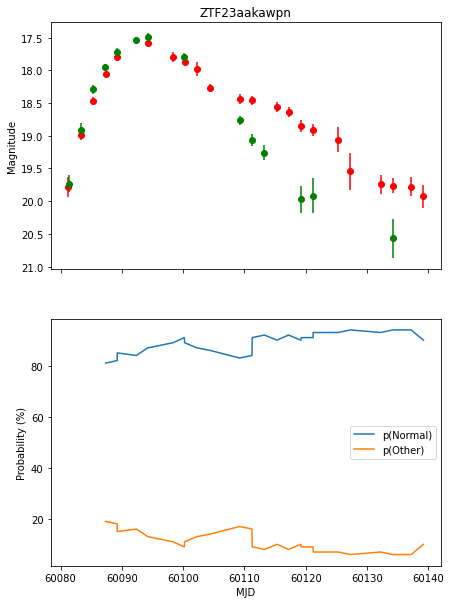

In [126]:
LAISS(l_or_ztfid_ref="ZTF23aakawpn", # ZTF23abcvqkd #ZTF23aaxoybh #ZTF23aakawpn # ANT2023z0zr3w2y9pd6 # ZTF21aaublej
                       scaler=scaler, 
                       pca=pca, 
                       idx_arr=idx_arr, 
                       index=index, 
                       lc_and_host_features=lc_and_host_features, 
                       n=8,
                       run_AD_model=True)

# TODO: clean up & make into LAISS.py file and arguments to run!

In [ ]:
for l in LAISS_RFC_AD_locus_ids:
    if l.startswith("ANT2023"):
        LAISS(l_or_ztfid_ref=l,
               scaler=scaler, 
               pca=pca, 
               idx_arr=idx_arr, 
               index=index, 
               lc_and_host_features=lc_and_host_features, 
               n=8,
               run_AD_model=True)

# TODO: get all TNS reports from ZTF data!...